In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import warnings

warnings.filterwarnings('ignore')

In [6]:
df = pd.read_csv("Structure.csv")


In [7]:
if 'Building_ID' in df.columns:
    df.drop('Building_ID', axis=1, inplace=True)

In [8]:
label_encoders = {}
for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le


In [9]:
target = 'Base_Shear_kN'
X = df.drop(columns=[target])
y = df[target]


In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [13]:
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "Support Vector Regressor": SVR(),
}

In [14]:
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    r2 = r2_score(y_test, predictions)
    print(f"{name}: RMSE = {rmse:.2f}, R² = {r2:.2f}")

Linear Regression: RMSE = 719.25, R² = -0.89
Decision Tree: RMSE = 534.06, R² = -0.04
Random Forest: RMSE = 444.83, R² = 0.28
Gradient Boosting: RMSE = 523.40, R² = 0.00
Support Vector Regressor: RMSE = 523.82, R² = -0.00


In [15]:
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    r2 = r2_score(y_test, predictions)
    results.append([name, rmse, r2])

In [16]:
results_df = pd.DataFrame(results, columns=["Model", "RMSE", "R² Score"])
print(results_df)


                      Model        RMSE  R² Score
0         Linear Regression  719.247539 -0.886726
1             Decision Tree  711.249094 -0.844996
2             Random Forest  447.952468  0.268160
3         Gradient Boosting  490.479050  0.122609
4  Support Vector Regressor  523.820494 -0.000730


<Axes: title={'center': 'Model Performance'}, xlabel='Model'>

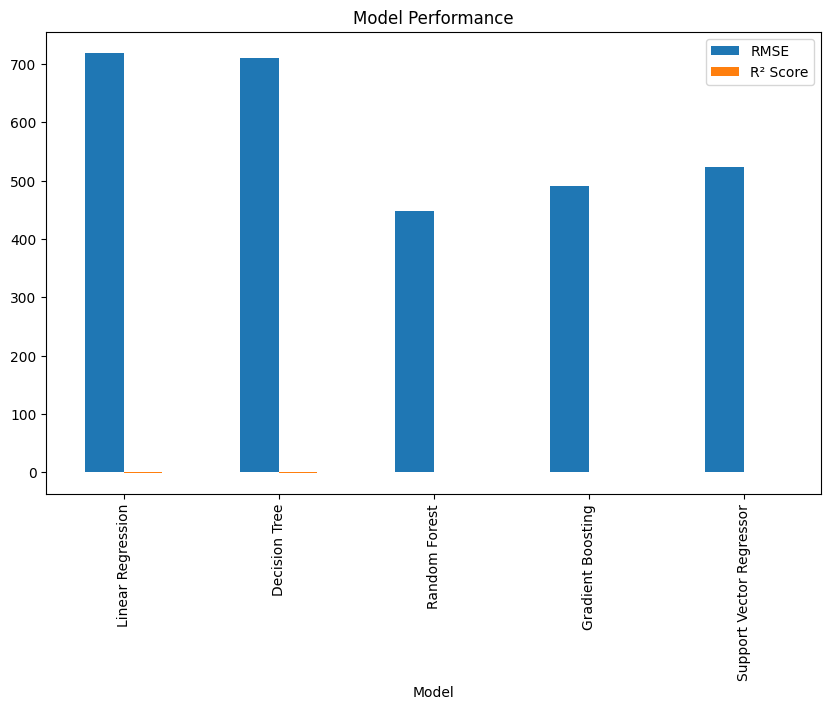

In [17]:
results_df.set_index("Model")[["RMSE", "R² Score"]].plot(kind="bar", figsize=(10,6), title="Model Performance")

<Axes: title={'center': 'Feature Importance'}>

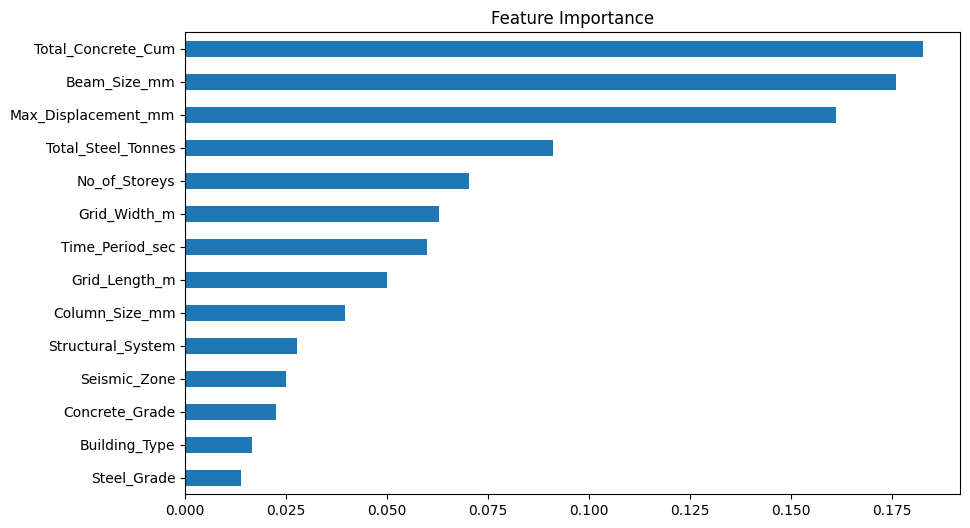

In [19]:
target_column = "Base_Shear_kN"
best_model = RandomForestRegressor().fit(X_train, y_train)

importances = best_model.feature_importances_
feature_importance = pd.Series(importances, index=df.drop(columns=[target_column]).columns)

feature_importance.sort_values().plot(kind="barh", figsize=(10,6), title="Feature Importance")

In [20]:
import joblib
joblib.dump(best_model, "best_etabs_model.pkl")
loaded_model = joblib.load("best_etabs_model.pkl")

In [3]:
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv("Structure.csv")

if "Building_ID" in df.columns:
    df.drop(columns=["Building_ID"], inplace=True)

label_encoders = {}
for col in df.select_dtypes(include="object").columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le


feature_columns = ["Building_Type", "No_of_Storeys", "Grid_Length_m", "Grid_Width_m",
                   "Column_Size_mm", "Beam_Size_mm", "Concrete_Grade", "Steel_Grade",
                   "Seismic_Zone", "Structural_System"]

target_columns = ["Base_Shear_kN", "Max_Displacement_mm", "Time_Period_sec",
                  "Total_Steel_Tonnes", "Total_Concrete_Cum"]

X = df[feature_columns]
y = df[target_columns]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

base_model = RandomForestRegressor()
multi_model = MultiOutputRegressor(base_model).fit(X_train, y_train)

print("✅ Model trained to predict multiple ETABS outputs!")


print("\nEnter Building Data for Prediction:\n")
user_input = {}

for col in feature_columns:
    value = input(f"Enter value for {col}: ")
    try:
        value = float(value)
    except:
        if col in label_encoders:
            if value in label_encoders[col].classes_:
                value = label_encoders[col].transform([value])[0]
            else:
                print(f"⚠️ Warning: '{value}' not seen before in {col}, defaulting to 0.")
                value = 0
    user_input[col] = value

new_data = pd.DataFrame([user_input])[feature_columns]
new_data_scaled = scaler.transform(new_data)

predictions = multi_model.predict(new_data_scaled)[0]

print("\n📊 Predicted Structural Outputs:")
for col, pred in zip(target_columns, predictions):
    print(f"{col}: {pred:.2f}")


✅ Model trained to predict multiple ETABS outputs!

Enter Building Data for Prediction:



Enter value for Building_Type:  5
Enter value for No_of_Storeys:  45
Enter value for Grid_Length_m:  145
Enter value for Grid_Width_m:  200
Enter value for Column_Size_mm:  55
Enter value for Beam_Size_mm:  45
Enter value for Concrete_Grade:  70
Enter value for Steel_Grade:  85
Enter value for Seismic_Zone:  85
Enter value for Structural_System:  45



📊 Predicted Structural Outputs:
Base_Shear_kN: 1259.07
Max_Displacement_mm: 28.61
Time_Period_sec: 1.18
Total_Steel_Tonnes: 60.39
Total_Concrete_Cum: 591.54
